In [20]:
import scipy.io as sio
from scipy import stats
from scipy.stats import mode
from scipy.stats import uniform

import os
import numpy as np
import pandas as pd
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.datasets import load_iris
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor as knr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import (train_test_split, RepeatedKFold, RandomizedSearchCV)
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import randint, expon 

In [4]:
fname = join(os.getcwd(),'data','data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

#y = np.int32(mat_contents['labels'].reshape(Nc))
y = mat_contents['labels'].reshape(Nc)

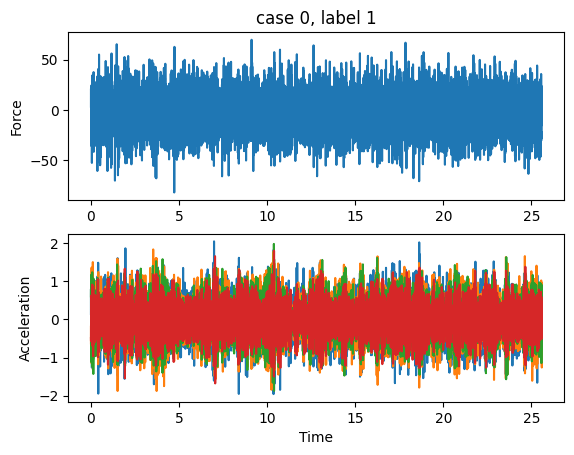

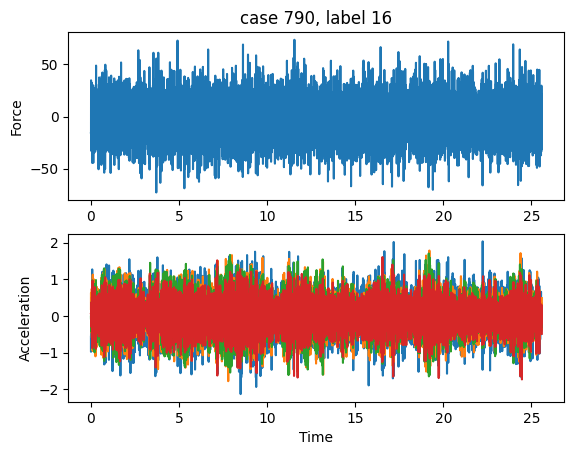

In [5]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [6]:
Ch2_ar = []
for i in range(850):
    res = AutoReg(Ch2.T[i], lags = 30).fit()
    Ch2_ar.append(res.params)
Ch3_ar = []
for i in range(850):
    res = AutoReg(Ch3.T[i], lags = 30).fit()
    Ch3_ar.append(res.params)
Ch4_ar = []
for i in range(850):
    res = AutoReg(Ch4.T[i], lags = 30).fit()
    Ch4_ar.append(res.params)
Ch5_ar = []
for i in range(850):
    res = AutoReg(Ch5.T[i], lags = 30).fit()
    Ch5_ar.append(res.params)

X1 = np.concatenate((Ch2_ar, Ch3_ar, Ch4_ar, Ch5_ar), axis = 1)
X1.shape

(850, 124)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.4, random_state=0)

In [9]:
X_train.shape

(510, 124)

In [10]:
y_train.shape

(510,)

In [11]:
iris = load_iris()
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(iris.data, iris.target)
search.best_params_

{'C': 2.195254015709299, 'penalty': 'l1'}

In [76]:
param_grids = []
param_grids.append( #SVR
        {
            "C": stats.loguniform(1e-1, 1e3),
            "kernel": ["linear", "rbf", "sigmoid"],
            "degree": stats.randint(2,5),
            "gamma": stats.loguniform(1e-4, 1e0),
        }
    )

param_grids.append( #KNN
        {
            "n_neighbors": stats.randint(2, 100),
            "weights": ["uniform", "distance"],
        }
    )

param_grids.append( #LRG
        {
            "C": stats.loguniform(1e-2, 1e2),
        }
    )

In [77]:
models = []
models.append(("SVR", SVC()))
models.append(("KNN", knn()))
models.append(("LogisticRegression", LogisticRegression()))

In [74]:
for k in range(3):
    rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=42)
    estimator = models[k][1]
    param_grid = param_grids[k]
    
    random_search = RandomizedSearchCV(estimator=estimator,
                                       scoring="accuracy",
                                       param_distributions=param_grid,
                                       n_iter=10, n_jobs = -1, cv=rkf,
                                       random_state=42)
    
    random_search.fit(X_train, y_train)
    yh_test = random_search.predict(X_test)
    
    print("Best Hyperparameters for", models[k][0], ":", random_search.best_params_)
    print("Best Accuracy:", random_search.best_score_)

C:\Users\lacuc\anaconda3\envs\Test_cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Hyperparameters for LogisticRegression : {'C': 2.5378155082656626}
Best Accuracy: 0.982313725490196
Best Hyperparameters for SVR : {'C': 3.14891164795686, 'degree': 2, 'gamma': 0.0005416754583247456, 'kernel': 'linear'}
Best Accuracy: 0.995843137254902
Best Hyperparameters for KNN : {'n_neighbors': 3, 'weights': 'distance'}
Best Accuracy: 0.9542352941176471
